In [2]:
import dask.dataframe as dd
import pandas as pd
from xgboost import dask as dxgb
from distributed import Client, LocalCluster
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
X_train = dd.read_parquet("dask_output/rmv_outlier_std_801010/X_train/")
X_validation = dd.read_parquet("dask_output/rmv_outlier_std_801010/X_valid/")
X_test = dd.read_parquet("dask_output/rmv_outlier_std_801010/X_test/")

y_train = dd.read_parquet("dask_output/rmv_outlier_std_801010/y_train_attack/")
y_validation = dd.read_parquet("dask_output/rmv_outlier_std_801010/y_valid_attack/")
y_test = dd.read_parquet("dask_output/rmv_outlier_std_801010/y_test_attack/")

In [5]:
y_train = y_train["Attack"]
y_validation = y_validation["Attack"]
y_test = y_test["Attack"]

In [6]:
cluster = LocalCluster(
    n_workers=6,        
    threads_per_worker=2, 
)
client = Client(cluster)

print(client)

<Client: 'tcp://127.0.0.1:58668' processes=6 threads=12, memory=15.73 GiB>


In [7]:
dtrain = dxgb.DaskDMatrix(client=client, data=X_train, label=y_train)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [8]:
dval = dxgb.DaskDMatrix(client=client, data=X_validation, label=y_validation)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [9]:
dtest = dxgb.DaskDMatrix(client=client, data=X_test, label=y_test)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [10]:
params = {
    "objective": "multi:softmax",
    "eval_metric": "merror",
    "tree_method": "hist",
    "max_depth": 6,
    "num_class": 10,
}
num_boost_round = 100

In [11]:
output = dxgb.train(
    client=client,
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dval, "val")],
    early_stopping_rounds=3,
)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [12]:
y_pred = dxgb.predict(client=client, model=output, data=dtest)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [13]:
y_pred.shape

(1270467,)

In [14]:
import numpy as np

In [15]:
y_pred = np.round(y_pred)

In [16]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9918179692979039


In [18]:
f1 = f1_score(y_test, y_pred, average="macro")
print("F1:", f1)

F1: 0.9043626366408468


In [34]:
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9984    0.9950    0.9967    551220
           1     0.9976    0.9969    0.9972    373217
           2     0.9642    0.9990    0.9813    127784
           3     0.9971    0.9804    0.9887    121788
           4     0.9572    0.9998    0.9780     60828
           5     0.9671    0.8438    0.9012     19176
           6     0.9850    0.9685    0.9767     15875
           7     0.8791    0.1556    0.2645       514
           8     1.0000    1.0000    1.0000        49
           9     1.0000    1.0000    1.0000        16

    accuracy                         0.9918   1270467
   macro avg     0.9746    0.8939    0.9084   1270467
weighted avg     0.9920    0.9918    0.9917   1270467



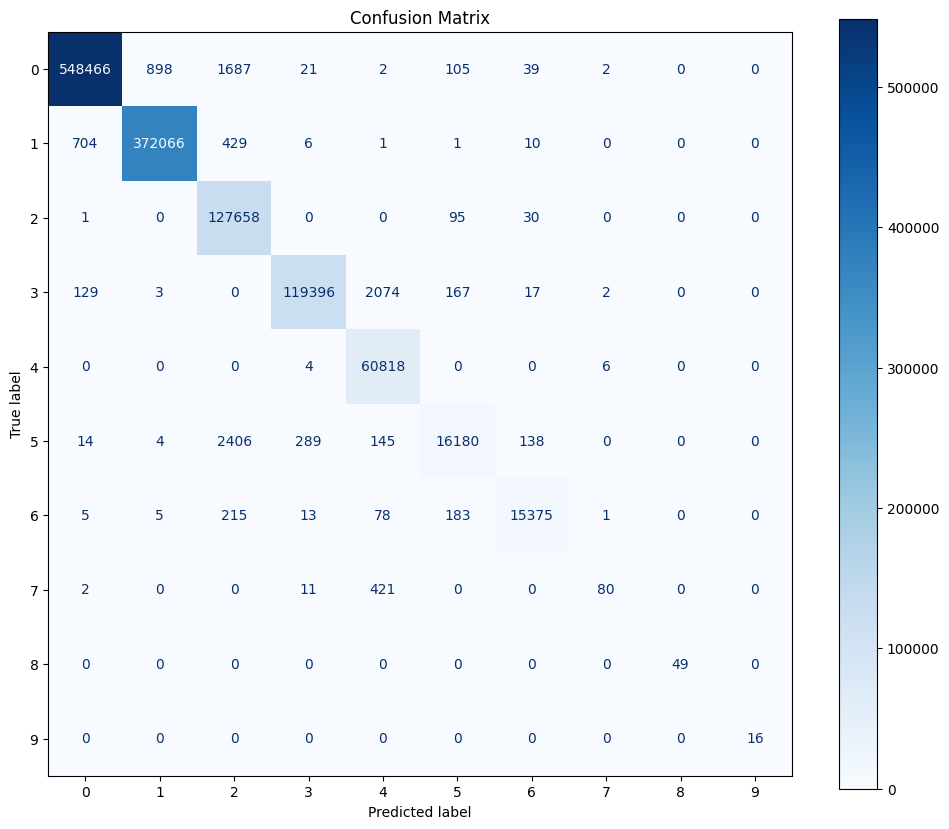

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

In [31]:
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

In [32]:
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Binary Accuracy (Benign vs Attack):", binary_accuracy)

Binary Accuracy (Benign vs Attack): 0.9971593122843805


In [33]:
binary_report = classification_report(y_test_binary, y_pred_binary, zero_division=0, digits=4)
print(binary_report)

              precision    recall  f1-score   support

           0     0.9984    0.9950    0.9967    551220
           1     0.9962    0.9988    0.9975    719247

    accuracy                         0.9972   1270467
   macro avg     0.9973    0.9969    0.9971   1270467
weighted avg     0.9972    0.9972    0.9972   1270467

